In [2]:
import analysis
import numpy as np
from importlib import reload
reload(analysis)
from analysis import System
from matplotlib import rc

cutoff = 1e6
# ("telescope", "Telescope"),
names = [("sagnac", "Sagnac"), ("split beam", "SplitBeam"), ("microphone", "Sagnac")]
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
systems = np.array([])
for n in names:
    systems = np.append(systems, System(n[0], ["../data/20230801/" + n[1] + "/iter_0.tdms"] + ["../data/20230801/" + n[1] + "/MinDetect/" + i for i in phis], SNR_freq_cut = cutoff, phis = [int(p[3:-5]) for p in phis],  SNR_freq_range = [10000, cutoff], SNR_resolution = 10))

# PSD of systems

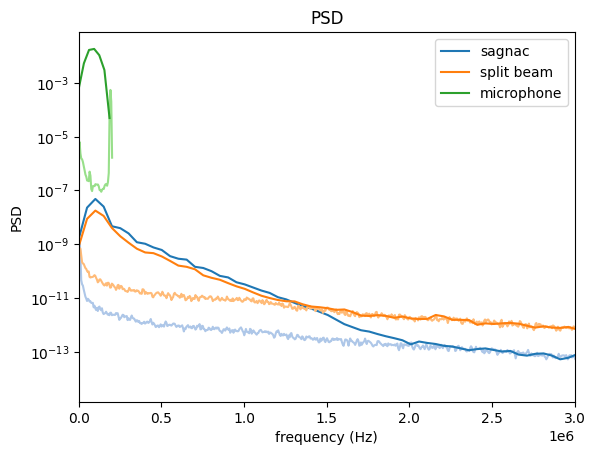

In [14]:
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq, irfft
fig, ax = plt.subplots(1, 1)
cmap = plt.colormaps['tab20']

def Daici(freq, dist = 0.1, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)

for s_i, s in enumerate(systems):
    ind = 2
    cutoff = 4e6
    if s.get_name()[:3] == "mic":
        s.set_data(ind = ind, mic_correct = True)
        dat = s.get_data()[ind]
        dat.apply("lowpass", cutoff = 2e5, inplace = True)
        dat.apply("bin_average", Npts = int(dat.r / (2 * 2e5)), inplace = True)
    else:
        s.set_data(ind = ind)
        dat = s.get_data()[ind]
        dat.apply("lowpass", cutoff = cutoff, inplace = True)
        dat.apply("bin_average", Npts = int(dat.r / (2 * cutoff)), inplace = True)
    # added this mess
    if s.get_name()[:3] != "mic":
        dat.apply("correct", response = Daici, recollect = True)
        if s.get_name() == "sagnac":
            dat.apply("calibrate", cal = np.mean(sagnac_cals), inplace = True)
        elif s.get_name() == "split beam":
            dat.apply("calibrate", cal = np.mean(split_cals), inplace = True)
            # calibrate individual collections here and then calculate new PSD
    freq_noise, psds_noise = dat.average("PSD", tmin = 1.5e-4, tmax = 3.5e-4)
    s.local_detrend([], ind, tmin = 0, tmax = 3.5e-4, inplace = True)
    if s.get_name()[:3] == "mic":
        freq_signal, psds_signal = dat.average("PSD", tmin = 4.14e-4, tmax = 4.48e-4)
    else:
        freq_signal, psds_signal = dat.average("PSD", tmin = 4.37e-4, tmax = 4.57e-4)
    ax.plot(freq_noise, psds_noise, color = cmap.colors[2 * s_i + 1])
    ax.plot(freq_signal, psds_signal, label = s.get_name(), color = cmap.colors[2 * s_i])
    # added this mess
    if s.get_name() == "sagnac":
        dat.apply("calibrate", cal = 1 / np.mean(sagnac_cals), inplace = True)
    elif s.get_name() == "split beam":
        dat.apply("calibrate", cal = 1 / np.mean(split_cals), inplace = True)
ax.set_yscale("log")
ax.set_xlim([0, 3e6])
ax.set_title("PSD")
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("PSD")
ax.legend()
fig.savefig("PSDvsFreqStrongShot.png")
plt.show()

# BW evolution of single shot

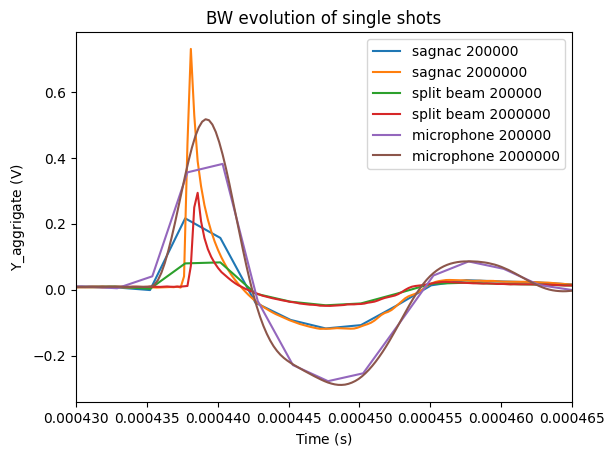

In [8]:
import matplotlib.pyplot as plt

freq_range = [2e6, 2e5]
fig, ax = plt.subplots()
for s in systems:
    ind = 0
    for freq in freq_range[::-1]:
        if s.get_name()[:3] == "mic":
            s.set_data(ind = ind, mic_correct = False)
        else:
            s.set_data(ind = ind)
        dat = s.get_data()[ind]
        if s.get_name() == "split beam":
            for c in dat.collection:
                c.x -= 0.17
        if s.get_name()[:3] == "mic":
            dat.apply("shift", tau = -2e-5, inplace = True)
        dat.apply("lowpass", cutoff = freq, inplace = True)
        dat.apply("bin_average", Npts = int(dat.r / (2 * freq)), inplace = True)
        dat.aggrigate(collection_slice = slice(1, len(dat.collection), 1))
        dat.agg.plot(ax = ax, label = s.get_name() + " " + str(int(freq)))
    ax.set_title("BW evolution of single shots")
    ax.set_xlim([4.3e-4, 4.65e-4])
    ax.legend()
    s.set_data(ind = ind)
fig.savefig("BW evolutions of single shots")
plt.show()

[16.25004187 17.39144074 17.32869278 16.95658858 15.79924684 16.11114221
 16.51287788 17.27988102 14.74071336 16.62213447 17.40153426 17.22875838
 16.37524635 18.95191786 16.59685942 16.0729227  15.08522144 16.06624126
 16.44623022 16.56878615 16.74286029 16.99623015 16.49160537 16.56377671
 16.69773004 16.52213567 18.39559948 16.67787093 16.26271723 17.26046082
 16.59245674 17.1394474  16.20121462 16.63463421 16.80225361 17.58210001
 16.7325939  17.22332704 16.69955212 17.21136123 16.61154069 16.39566816
 18.19658125 16.00406997 16.75800013 16.40177874 16.62460768 16.10016114
 17.96950459 17.41139486 17.71662492 16.63183407 16.71880137 16.894826
 15.67959479 16.48744632 17.34163045 16.69310265 16.17133758 16.80142998
 16.59891336 16.85071709 16.35141979 16.60582878 16.74246566 16.71415886
 16.31320685 16.70759398 17.7628048  16.50915208 18.52799704 16.47789225
 15.99762007 17.14408547 16.12331807 17.05357471 16.39813454 17.29099938
 17.11756743 16.30270807 15.51697583 16.332929   16.7

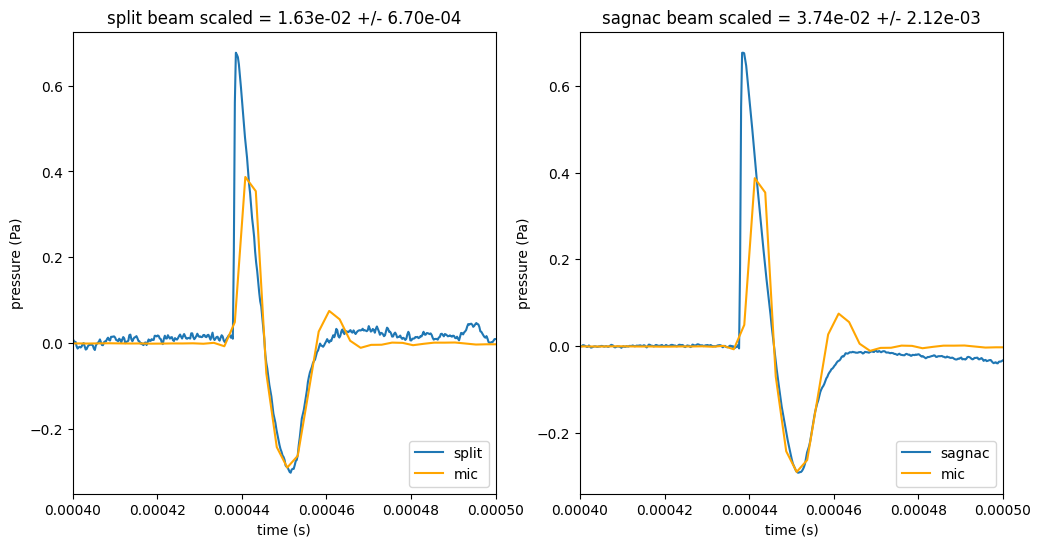

In [3]:
import matplotlib.pyplot as plt
from analysis import mic_tau_shift
from analysis import calc_cal_factor

def Daici(freq, dist = 0.1, T = 20, n = 1.0003):
    from brownian import get_sound_speed
    from scipy.special import kv
    a = get_sound_speed(T, 0.5, 99e3)
    c = dist / a
    s = c * freq * 2j * np.pi
    return s * kv(1, s) * np.exp(s)
def calc_calibration_factors(laser, mic):
    cals = []
    for col_i in range(1, len(laser.get_data()[dat].collection)):
        t = mic_tau_shift(laser, mic, dat, col_i)
        mic.get_data()[dat].apply("shift", tau = t, inplace = True)
        cals.append(calc_cal_factor(laser.get_data()[dat].collection[col_i], mic.get_data()[dat].collection[col_i], 0))
        mic.get_data()[dat].apply("shift", tau = -t, inplace = True)
    return cals

dat = 0
cutoff = 2e6
col_i = 1
sagnac = systems[0]
split = systems[1]
mic = systems[2]
mic.set_data(ind = dat)
sagnac.set_data(ind = dat)
split.set_data(ind = dat)

sagnac.get_data()[dat].apply("lowpass", cutoff = cutoff, inplace = True)
sagnac.get_data()[dat].apply("bin_average", Npts = int(sagnac.get_data()[dat].r / (2 * cutoff)), inplace = True)
sagnac.get_data()[dat].apply("correct", response = Daici, recollect = True)
sagnac.local_detrend([], dat, 3.5e-4, 4e-4, True)

split.get_data()[dat].apply("lowpass", cutoff = cutoff, inplace = True)
split.get_data()[dat].apply("bin_average", Npts = int(split.get_data()[dat].r / (2 * cutoff)), inplace = True)
split.get_data()[dat].apply("correct", response = Daici, recollect = True)
split.local_detrend([], dat, 3.5e-4, 4e-4, True)

mic.get_data()[dat].apply("lowpass", cutoff = 2e5, inplace = True)
mic.get_data()[dat].apply("bin_average", Npts = int(mic.get_data()[dat].r / (2 * 2e5)), inplace = True)
mic.local_detrend([], dat, 0, 3.5e-4, True)

sagnac_cals = calc_calibration_factors(sagnac, mic)
split_cals = calc_calibration_factors(split, mic)
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(12, 6)

ax[0].set_xlim([4e-4, 5e-4])
ax[1].set_xlim([4e-4, 5e-4])

ind = 1

t = mic_tau_shift(split, mic, dat, col_i)
split.get_data()[dat].apply("calibrate", cal = split_cals[ind - 1], inplace = True)
mic.get_data()[dat].apply("shift", tau = t, inplace = True)
# split.get_data()[dat].aggrigate(collection_slice = slice(1, len(split.get_data()[dat].collection), 1))
# split.get_data()[dat].agg.plot(ax = ax[0], c = "k", label = "split")
# ax[0].fill_between(split.get_data()[dat].agg.t, split.get_data()[dat].agg.x - np.std(split_cals), split.get_data()[dat].agg.x + np.std(split_cals), alpha = 0.2)
ax[0].plot(split.get_data()[dat].collection[ind].t, split.get_data()[dat].collection[ind].x, label = "split")
ax[0].plot(mic.get_data()[dat].collection[ind].t, mic.get_data()[dat].collection[ind].x, color = "orange", label = "mic")
split.get_data()[dat].apply("calibrate", cal = 1 / split_cals[ind], inplace = True)
mic.get_data()[dat].apply("shift", tau = -t, inplace = True)
ax[0].set_title("split beam scaled = " + "{:.2e}".format(1 / split_cals[ind - 1]) + " +/- " + "{:.2e}".format(np.std(1 / np.array(split_cals))))
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("pressure (Pa)")

t = mic_tau_shift(sagnac, mic, dat, col_i)
sagnac.get_data()[dat].apply("calibrate", cal = sagnac_cals[ind - 1], inplace = True)
mic.get_data()[dat].apply("shift", tau = t, inplace = True)
# sagnac.get_data()[dat].aggrigate(collection_slice = slice(1, len(sagnac.get_data()[dat].collection), 1))
# sagnac.get_data()[dat].agg.plot(ax = ax[1], c = "k", label = "sagnac")
# ax[1].fill_between(sagnac.get_data()[dat].agg.t, sagnac.get_data()[dat].agg.x - np.std(sagnac_cals), sagnac.get_data()[dat].agg.x + np.std(sagnac_cals), alpha = 0.2)
ax[1].plot(sagnac.get_data()[dat].collection[ind].t, sagnac.get_data()[dat].collection[ind].x, label = "sagnac")
ax[1].plot(mic.get_data()[dat].collection[ind].t, mic.get_data()[dat].collection[ind].x, color = "orange", label = "mic")
sagnac.get_data()[dat].apply("calibrate", cal = 1 / np.mean(sagnac_cals), inplace = True)
mic.get_data()[dat].apply("shift", tau = -t, inplace = True)
ax[1].set_title("sagnac beam scaled = " + "{:.2e}".format(1 / sagnac_cals[ind - 1]) + " +/- " + "{:.2e}".format(np.std(1 / np.array(sagnac_cals))))
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("pressure (Pa)")

print(1e3 / np.array(split_cals))
print(1e3 / np.array(sagnac_cals))

ax[0].legend(loc = "lower right")
ax[1].legend(loc = "lower right")
fig.savefig("ScaledBeamsvsMic")
plt.show()
# diff file1 file2 => see differences

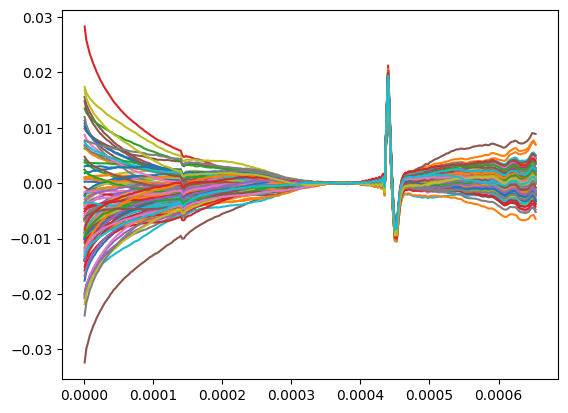

In [12]:
for i in sagnac.get_data()[dat].collection[1:]:
    plt.plot(i.t, i.x)

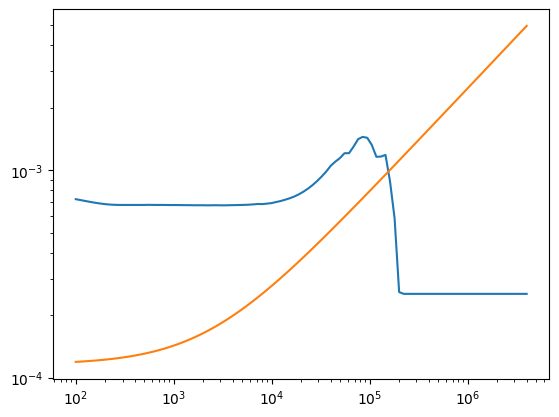

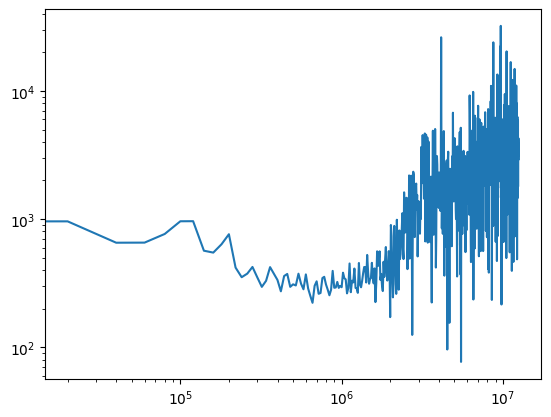

In [6]:
from acoustic_entrainment import mic_response
sagnac = systems[0]
mic = systems[2]
mic.set_data(ind = 1, mic_correct = True)
sagnac.set_data(ind = 1)
sagnac.local_detrend([], dat, 0, 4e-4, True)
mic.local_detrend([], dat, 0, 3.5e-4, True)

f_range = np.geomspace(100, 4e6, 100)
plt.loglog(f_range, mic_response(f_range))
plt.loglog(f_range, (1 / np.mean(sagnac_cals)) * Daici(f_range))
mic.get_data()[dat].apply("shift", tau = t, inplace = True)
mic_sig = mic.get_data()[1].collection[2].time_gate(tmin = 4.3e-4, tmax = 4.8e-4)[1]
l_sig = sagnac.get_data()[1].collection[2].time_gate(tmin = 4e-4, tmax = 4.5e-4)[1]
mic.get_data()[dat].apply("shift", tau = -t, inplace = True)
plt.show()
x = np.fft.rfftfreq(len(mic_sig), 1/25e6)
plt.loglog(x, np.abs(np.fft.rfft(mic_sig) / np.fft.rfft(l_sig)))
plt.show()